In [ ]:
!pip install scikeras
!pip install keras-tuner

In [1]:
import os
import keras
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import keras_tuner as kt
from sklearn import metrics
from pickle import dump,load
import matplotlib.pyplot as plt
from keras.models import Sequential
from pandas_datareader import data as pdr
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from scikeras.wrappers import KerasRegressor
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from sklearn.linear_model import LogisticRegression
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import GridSearchCV, train_test_split

In [3]:
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir('/content/drive/MyDrive/GDSC AI Stock')

In [8]:
## Yahoo Finance for TSLA and VIX

yf.pdr_override()
df = pdr.get_data_yahoo("TSLA", start = "2015-01-01", end = "2023-12-31").reset_index()
vix = pdr.get_data_yahoo("^VIX", start = "2015-01-01", end = "2023-12-31").reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
fin = pd.read_csv('./Financial Statement.csv')

df['Date'] = pd.to_datetime(df['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])
fin['Date'] = pd.to_datetime(fin['Date'])

df.drop(columns = ['Adj Close'], inplace = True)
vix = vix[['Date', 'Close']]
fin = fin[['Date', 'Gross Margin (YoY%)', 'Operating Margin (YoY%)', 'Quick Ratio (YoY%)', 'EPS Growth (USD)']]
df['Delta'] = round(df['Close'].pct_change()*100, 4)
df.dropna(inplace = True)

In [10]:
df = pd.merge(left = df, right = vix, left_on = 'Date', right_on = 'Date', suffixes = ('_TSLA', '_VIX'), how = 'left')
df = pd.merge(left = df, right = fin, left_on = 'Date', right_on = 'Date', how = 'left')
df.set_index('Date', inplace = True)

In [11]:
def custom_ffill(series):

    previous_value = None
    day = 0

    for i, value in series.items():

        if pd.isna(value):
            day += 1
            if previous_value is not None:

                series[i] = previous_value / 2
                previous_value = previous_value / 2

                # if abs(previous_value) <= float(1e-4):
                if day > 14:
                    previous_value = 0
        else:
            previous_value = value
            day = 0

    return series

for c in df:
    df[c] = custom_ffill(df[c])

df.dropna(inplace = True)
df.reset_index(inplace = True)

In [12]:
df['Open_Close'] = 0.0
df['High_Low'] = 0.0

for i in range(len(df)):
    df['Open_Close'][i] = (df['Open'][i] - df['Close_TSLA'][i]) * 100 / df['Open'][i]
    df['High_Low'][i] = (df['High'][i] - df['Low'][i]) * 100 / df['Low'][i]

In [13]:
df['Target'] = df['Close_TSLA'].shift(-1)
df.dropna(inplace = True)

features = df[["Close_TSLA", "Volume", "Close_VIX", "Gross Margin (YoY%)", "Operating Margin (YoY%)", "Quick Ratio (YoY%)", "EPS Growth (USD)", "Open_Close", "High_Low"]]
target = df['Target']

In [14]:
f_scaler = MinMaxScaler()
t_scaler = MinMaxScaler()
features_scaled = f_scaler.fit_transform(features)
target_scaled = t_scaler.fit_transform(target.values.reshape(-1, 1))

num_train = int(len(features_scaled) * 0.9)

x_train = features_scaled[:num_train]
x_test = features_scaled[num_train:]

y_train = target_scaled[:num_train]
y_test = target_scaled[num_train:]

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train.shape, x_test.shape

((1982, 1, 9), (221, 1, 9))

### RandomSearch

In [15]:
def build_model(hp):
    model = Sequential()

    model.add(
        LSTM(hp.Int('input_unit', min_value = 32, max_value = 512, step = 32), return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2]))
        )

    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(
            LSTM(hp.Int(f'lstm_{i}_units', min_value = 32, max_value = 512, step = 32), return_sequences = True)
            )

    model.add(
        Dropout(hp.Float('Dropout_rate_1', min_value = 0, max_value = 0.5, step = 0.1))
        )

    model.add(
        LSTM(hp.Int('layer_2_neurons', min_value = 32, max_value = 512, step = 32))
        )

    model.add(
        Dropout(hp.Float('Dropout_rate_2', min_value = 0, max_value = 0.5, step = 0.1))
        )

    model.add(Dense(hp.Int('dense_1_units', min_value = 32, max_value = 512, step = 32)))
    model.add(Dense(1))

    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

    return model

tuner = RandomSearch(
        build_model,
        objective = 'val_mse',
        max_trials = 20,
        executions_per_trial = 1,
        overwrite = True,
        project_name = "LSTM_0316v"
)

tuner.search(
        x = x_train,
        y = y_train,
        epochs = 20,
        batch_size = 32,
        validation_data = (x_test, y_test)
)

best_model = tuner.get_best_models(num_models = 1)[0]
best_model.summary()

Trial 20 Complete [00h 00m 26s]
val_mse: 0.00031786112231202424

Best val_mse So Far: 0.0003008226631209254
Total elapsed time: 00h 10m 34s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1069056   
                                                                 
 lstm_1 (LSTM)               (None, 1, 96)             233856    
                                                                 
 lstm_2 (LSTM)               (None, 1, 192)            221952    
                                                                 
 lstm_3 (LSTM)               (None, 1, 480)            1292160   
                                                                 
 lstm_4 (LSTM)               (None, 1, 352)            1172864   
                                                                 
 dropout (Dropout)           (None, 1, 352)     

In [16]:
loss = best_model.evaluate(x_test, y_test)
print(f'Mean Squared Error on Test Data: {round(loss[0], 4)}')

7/7 [==============================] - 4s 8ms/step - loss: 3.0082e-04 - mse: 3.0082e-04
Mean Squared Error on Test Data: 0.0003


In [17]:
x_new = np.reshape(features_scaled[-1], (1, 1, features_scaled.shape[1]))
predicted_scaled = best_model.predict(x_new)
predicted = t_scaler.inverse_transform(predicted_scaled)
print(f'Predicted Close_TSLA for the next day: {predicted[0][0]}')

1/1 [==============================] - 2s 2s/step
Predicted Close_TSLA for the next day: 253.73292541503906


In [18]:
### Predict for testing data

predictions = best_model.predict(x_test)
predictions = t_scaler.inverse_transform(predictions)

7/7 [==============================] - 0s 5ms/step


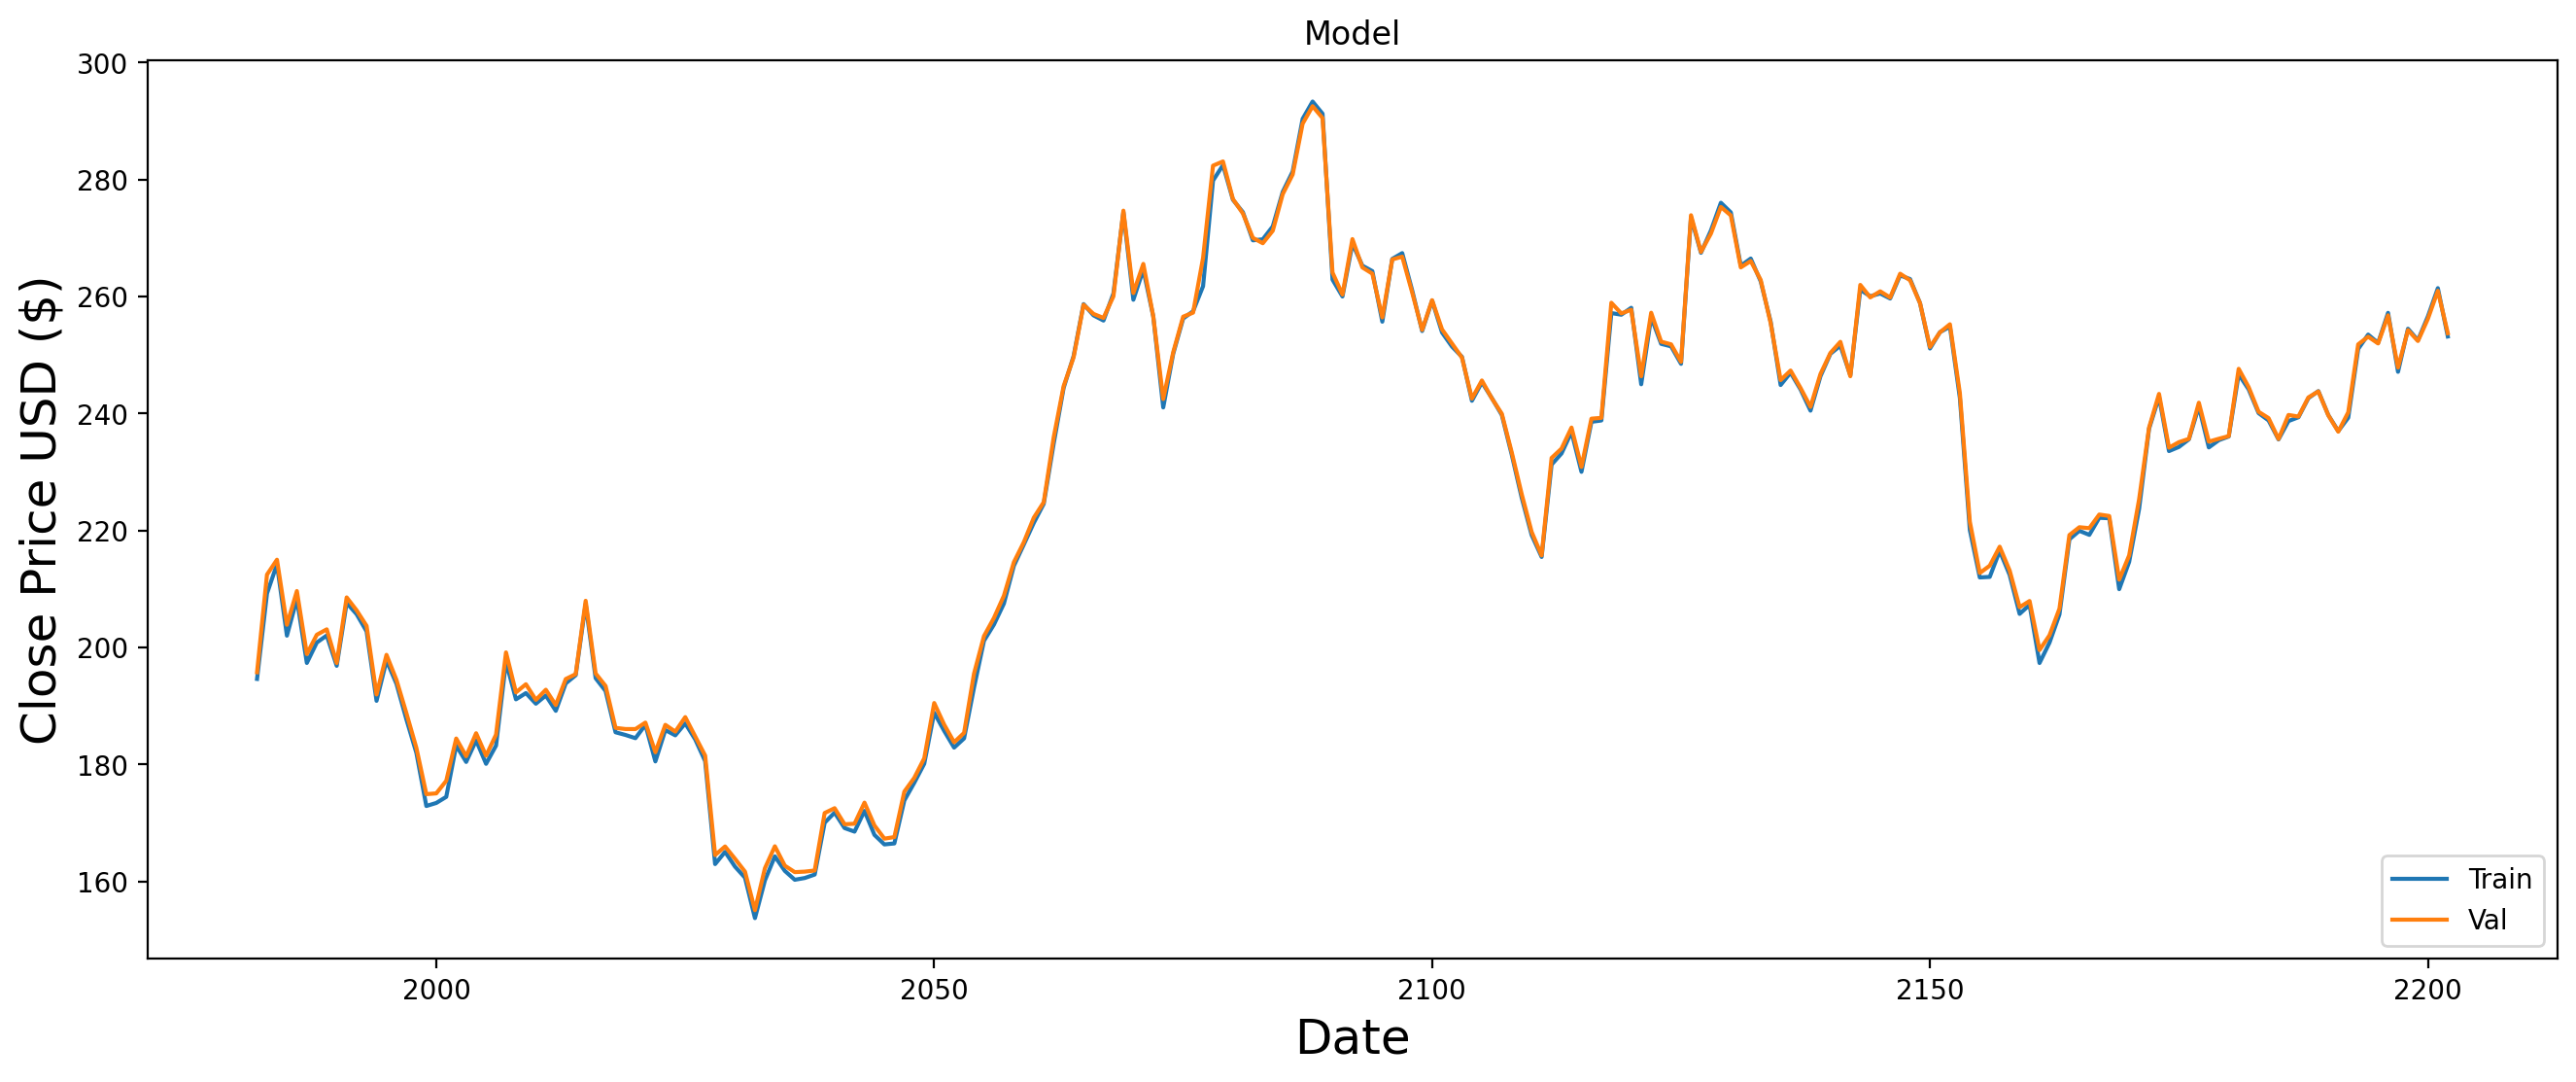

In [19]:
train = df[['Close_TSLA']][:num_train]
valid = df[['Close_TSLA']][num_train:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,6))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
# plt.plot(train['Close_TSLA'])
plt.plot(valid[['Close_TSLA', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [20]:
### Simply predict for next 7 day

result = []
for i in range(7):
    predicted_scaled = best_model.predict(x_new)
    x_new[0, 0, 0] = predicted_scaled[0, 0]
    predicted = t_scaler.inverse_transform(predicted_scaled)
    result.append(predicted[0, 0])

result

1/1 [==============================] - 0s 20ms/step


[253.73293, 254.27806, 254.8154, 255.34508, 255.86705, 256.38147, 256.88834]

In [21]:
save_model(best_model, "GDSC_TSLA_LSTM.h5")
dump(f_scaler, open('Features_Scaler.pkl', 'wb'))
dump(t_scaler, open('Target_Scaler.pkl', 'wb'))